In [1]:
import os
import sys
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import model_from_json
from SANet import SANet
from utils import load_img, gen_x_y, eval_loss, gen_paths, ssim_eucli_loss


# Settings
net = 'SANet'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
dataset = "B"

img_paths_test, img_paths_train, img_paths_val = gen_paths(path_file_root='data/paths_train_val_test', dataset=dataset)
img_paths_train = list(set(img_paths_train) - set(img_paths_val))
x_train, y_train, img_paths_train = gen_x_y(img_paths_train, 'train')
print(len(x_train), len(y_train), len(img_paths_train))
x_val, y_val, img_paths_val = gen_x_y(img_paths_val, 'val')
print(len(x_val), len(y_val), len(img_paths_val))
weights_dir = 'weights_' + dataset
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

Using TensorFlow backend.


380 380 380
20 20 20


In [ ]:
# # Random cropping on training set
# x_train, y_train = [], []
# num_crop = 2
# for idx_x in range(len(x_train_ori)):
#     up_range_x, left_range_x = (np.array(x_train_ori[idx_x].shape[1:-1]) / 2).astype(np.int)
#     up_range_y, left_range_y = (np.array(y_train_ori[idx_x].shape[1:-1]) / 2).astype(np.int)
#     x_ = x_train_ori[idx_x]
#     y_ = y_train_ori[idx_x]
#     for idx_crop in range(num_crop):
#         up_x = random.randint(0, up_range_x-1)
#         left_x = random.randint(0, left_range_x-1)
#         x_train.append(x_[:, up_x:up_x+up_range_x, left_x:left_x+left_range_x, :])
#         up_y = random.randint(0, up_range_y-1)
#         left_y = random.randint(0, left_range_y-1)
#         y_train.append(y_[:, up_y:up_y+up_range_y, left_y:left_y+left_range_y, :])
# #         # Flip horizontally
# #         x_train.append(x_[:, up_x:up_x+up_range_x, left_x:left_x+left_range_x, :][:, :, ::-1, :])
# #         y_train.append(y_[:, up_y:up_y+up_range_y, left_y:left_y+left_range_y, :][:, :, ::-1, :])
# # Shuffle
# idx_shuffle = random.shuffle(list(range(len(x_train))))
# x_train = np.array(x_train).tolist()
# y_train = np.array(y_train).tolist()
# print(len(x_train), len(y_train), len(img_paths_train))

In [2]:
# Model
model = SANet()
model.summary()
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss=ssim_eucli_loss)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 48          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 432         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 1 1200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (

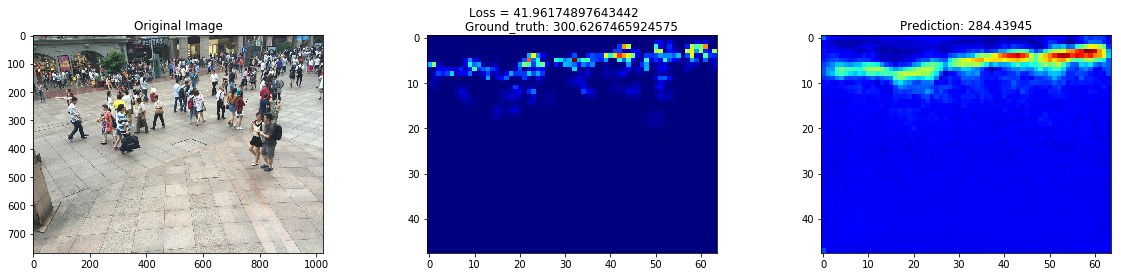

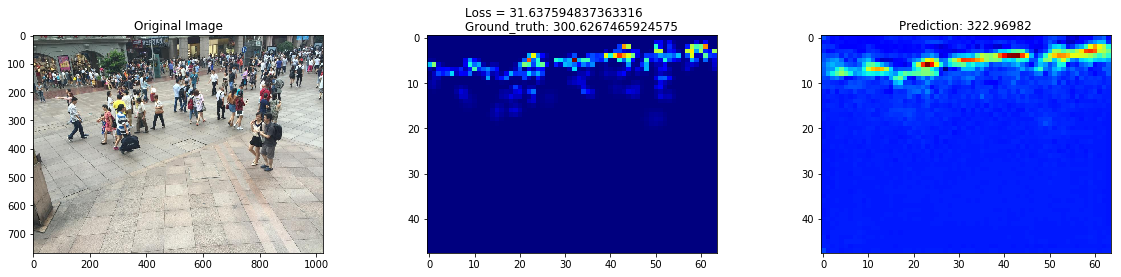

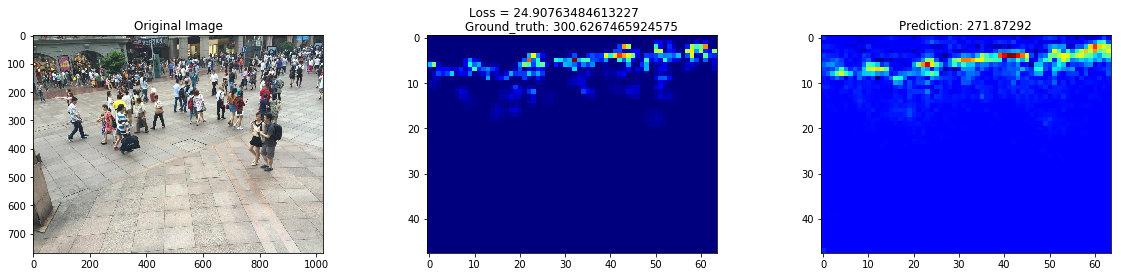

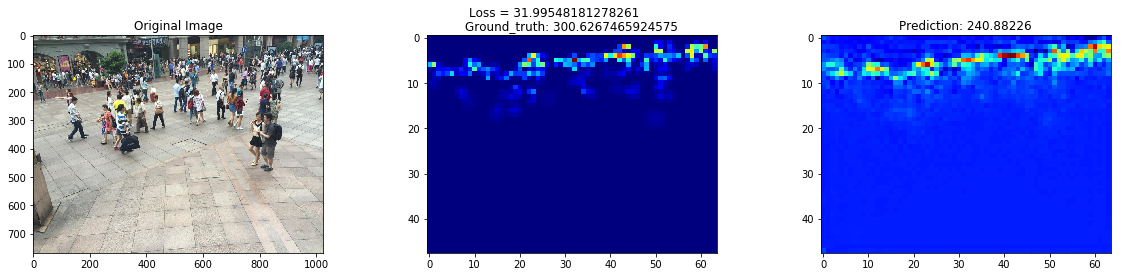

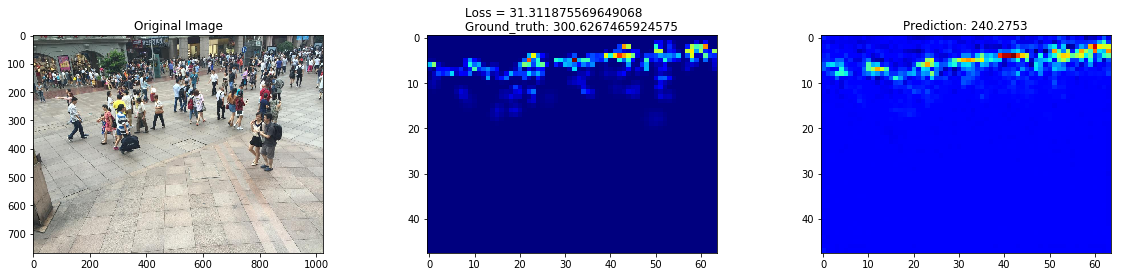

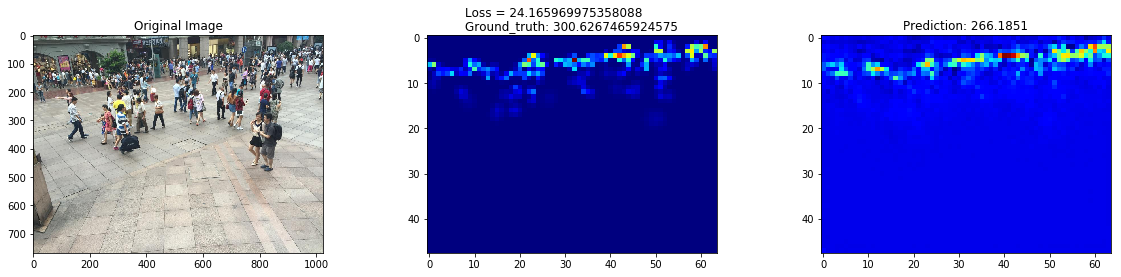

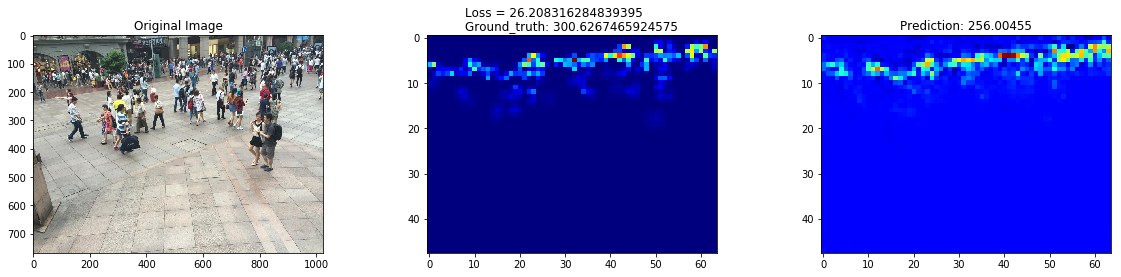

In [ ]:
# Settings
lossDMD = 12580
lossMAE = 12580
counter_train = 0
lossesDMD = []
lossesMAE = []
mae = 10086
epoch_train = 200
val_rate = 0.5
path_val_display = img_paths_val[0]
x_val_display = load_img(path_val_display)
y_val_display = np.squeeze(y_val[0])
with open('./models/{}.json'.format(net), 'w') as fout:
    fout.write(model.to_json())

# Training
time_st = time.time()
for epoch in range(epoch_train):
#     if epoch < epoch_train * 0.8:
#         val_rate = 0.5
#     else:
#         val_rate = 0.2
    for i in range(len(x_train)):
        x_, y_ = x_train[i], y_train[i]
        model.fit(x_, y_, verbose=0)
        counter_train += 1
        if counter_train % (len(x_train)*val_rate) == 0:
            # Calc loss
            lossDMD, lossMAE = eval_loss(model, x_val, y_val)
            lossesDMD.append(lossDMD)
            lossesMAE.append(lossMAE)
            if (lossMAE < mae and epoch_train > 0) or lossMAE < 20:
                mae = lossMAE
                model.save_weights(
                    os.path.join(weights_dir, '{}_lossMAE{}_lossDMD{}_epoch{}-{}.hdf5'.format(
                        net, round(lossMAE, 3), round(lossDMD, 3), epoch, counter_train%len(x_train)
                    ))
                )
                model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
            if counter_train % (len(x_train)*20) == 0:
                pred = np.squeeze(model.predict(np.expand_dims(x_val_display, axis=0)))
                # show prediction
                fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
                ax_x_ori.imshow(cv2.cvtColor(cv2.imread(path_val_display), cv2.COLOR_BGR2RGB))
                ax_x_ori.set_title('Original Image')
                ax_y.imshow(y_val_display, cmap=plt.cm.jet)
                ax_y.set_title('Ground_truth: ' + str(np.sum(y_val_display)))
                ax_pred.imshow(pred, cmap=plt.cm.jet)
                ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
                plt.suptitle('Loss = ' + str(lossMAE))
                plt.show()
                if (epoch+1) % 200 == 0:
                    # plot val_loss
                    plt.plot(lossesDMD, 'r')
                    plt.plot(lossesMAE, 'b')
                    plt.legend(['Loss_Density_Map_Distance', 'Loss_MAE'])
                    plt.title('Loss')
                    plt.show()
        time_now = time.time()
        time_consuming = time_now - time_st
        sys.stdout.write('In epoch {}_{}, with Mean_Density_Map_Distance={}, MAE={}, time consuming={}m-{}s\r'.format(
            epoch, counter_train%len(x_train), round(lossDMD, 3), round(lossMAE, 3),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()

In [ ]:
loss_dir = 'loss_' + dataset
if not os.path.exists(loss_dir):
    os.mkdir(loss_dir)
np.savetxt(os.path.join(loss_dir, 'loss_DMD.txt'), lossesDMD)
np.savetxt(os.path.join(loss_dir, 'loss_MAE.txt'), lossesMAE)

plt.plot(lossesDMD, 'r')
plt.plot(lossesMAE, 'b')
# plt.ylim(bottom=15, top=30)
plt.legend(['Mean Density Map Distance', 'MAE'])
plt.title('Loss -- {} epochs'.format(epoch_train))
plt.savefig('./images/loss_{}.jpg'.format(dataset))
plt.show()

In [ ]:
# Test on a single model
model.load_weights('./weights_B/SANet_lossMAE19.973_lossDMD133.279_epoch238-0.hdf5')
x_test, y_test, img_paths_test = gen_x_y(img_paths_test, 'test')
lossesDMD_test = []
lossesMAE_test = []
for i in range(len(y_test)):
    lossDMD_test, lossMAE_test = eval_loss(model, x_test[i:i+1], y_test[i:i+1])
    lossesDMD_test.append(lossDMD_test)
    lossesMAE_test.append(lossMAE_test)
    if i % (len(y_test)//3) == 0:
        pred = np.squeeze(model.predict(x_test[i]))
        fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
        ax_x_ori.imshow(cv2.cvtColor(cv2.imread(img_paths_test[i]), cv2.COLOR_BGR2RGB))
        ax_x_ori.set_title('Original Image')
        ax_y.imshow(np.squeeze(y_test[i]), cmap=plt.cm.jet)
        ax_y.set_title('Ground_truth: ' + str(np.sum(y_test[i])))
        ax_pred.imshow(pred, cmap=plt.cm.jet)
        ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
        plt.show()
print('Over all test set, Mean_Density_Map_Distance={}, MAE={}'.format(np.mean(lossesDMD_test), np.mean(lossesMAE_test)))

In [ ]:
# Load best model
print(len(x_test), len(y_test), len(img_paths_test))
with open('models/{}.json'.format(net), 'r') as fin:
    model_test = model_from_json(fin.read())
ms = [
    m for m in sorted(
        sorted(os.listdir(weights_dir))[1:],
        key=lambda x: float(x.split('MAE')[-1].split('_')[0])
    ) if float(m.split('MAE')[-1].split('_')[0]) < 30
]
MAE_final = []
num_model = len(ms)
for i, m in enumerate(ms):
    print('Test on the {}-th/{} model {}'.format(i+1, num_model, m), end='')
    model_test.load_weights(os.path.join(weights_dir, m))
    # On test set
    lossesDMD_test = []
    lossesMAE_test = []
    for i in range(len(y_test)):
        lossDMD_test, lossMAE_test = eval_loss(model_test, x_test[i:i+1], y_test[i:i+1])
        lossesDMD_test.append(lossDMD_test)
        lossesMAE_test.append(lossMAE_test)
        if i % (len(y_test)//3) == 0:
            print('..', end='')
    print('\nMDMD={}, MAE={}'.format(np.mean(lossesDMD_test), np.mean(lossesMAE_test)))
    MAE_final.append(np.mean(lossesDMD_test))
print('Best MAE:', np.min(MAE_final))